# Testing inferencing

Build functions to padd a given wave recordign to the 10 second limit

In [2]:
import torch
model = torch.load('model_test_mel_100_epochs')

# Test recordign

In [3]:
!pip install sounddevice
!pip install scipy
!pip install wavio

                                              0.0/199.7 kB ? eta -:--:--
     -------------------------------        163.8/199.7 kB 5.0 MB/s eta 0:00:01
     -------------------------------------- 199.7/199.7 kB 4.0 MB/s eta 0:00:00


In [120]:
# import required libraries
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv

folder = 'user_generated_recordings/'

# Sampling frequency
freq = 16000
 
# Recording duration
duration = 10
channels = 1
 
# Start recorder with the given values
# of duration and sample frequency
recording = sd.rec(int(duration * freq),
                   samplerate=freq, channels=1)
 
# Record audio for the given number of seconds

time.sleep(duration)
 
# This will convert the NumPy array to an audio
# file with the given sampling frequency



In [121]:
write(folder+ "recording0_11.wav", freq, recording)

In [122]:
import torchaudio
from IPython.display import Audio
#play clip

waveform, rsr  = torchaudio.load(folder + 'recording0_11.wav')
Audio(waveform.numpy()[0], rate=rsr)

In [123]:
print(rsr)
print(waveform.shape)

16000
torch.Size([1, 160000])


# Create padding

In [124]:

offset = 0

padded_waveform = torch.zeros(1,10*rsr)

l_waveform = waveform.shape[1]
padded_waveform[:,offset:offset+l_waveform] = waveform

padded_waveform.shape

torch.Size([1, 160000])

# Apply spectrogram

In [125]:
import torchaudio.transforms as T

#these will have to be hard coded in
number_frequencies = 151
number_time_steps = 400
sample_rate = rsr
spectrogram =  T.MelSpectrogram(sample_rate,
                                n_fft=number_time_steps,
                                n_mels = number_frequencies,
                                normalized = True)

spec = spectrogram(padded_waveform)

print(spec.shape)




torch.Size([1, 151, 801])


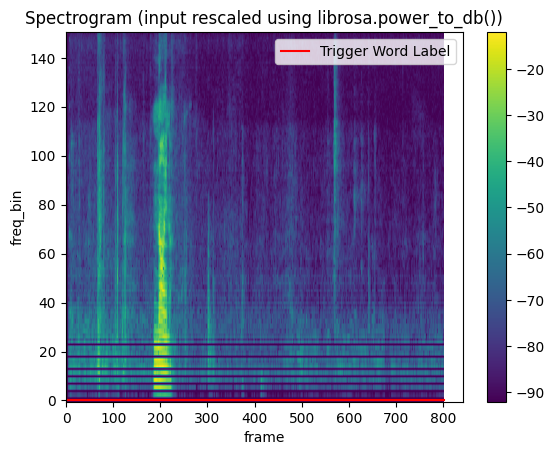

In [126]:
# plot 
from data_loading import plot_spectrogram 
label = torch.zeros(1,spec.shape[-1])

plot_spectrogram(spec[0],label, title=None, ylabel='freq_bin', aspect='auto', xmax=None)

# Now inference

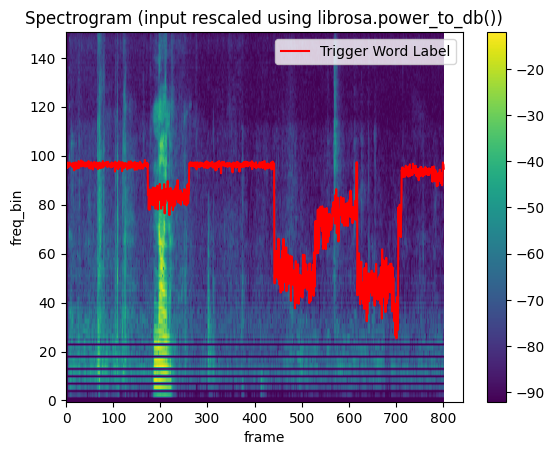

In [127]:
label_out = model(spec)

plot_spectrogram(spec[0],label_out.detach().numpy(), title=None, ylabel='freq_bin', aspect='auto', xmax=None)

In [128]:
print(torch.max(label_out),torch.min(label_out))


tensor(0.9828, grad_fn=<MaxBackward1>) tensor(0.2543, grad_fn=<MinBackward1>)


#  Reaction to probability
If probability is > 0.8 for a period then perform an action -   need to this to happen over time - which is tricky


Added in gradient to stop multiple chimes 

In [154]:
cut_off =0.8

label_out_bool = torch.where(label_out > cut_off, 1.0, 0.0)

grad = torch.gradient(label_out_bool[0])
grad[0]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [158]:
# Loop through label_out - delaying 
import time 
spec_time = label_out.shape[-1]
time_fraction = 10/spec_time

#functionality not implimented yet to stop multiple chimes 
delay= False 

#so this happens in real time  or not - or not is for testing portion 
real_time = False

I_lag = 0
for I in range(0,spec_time):
    
    if real_time == True:
        time.sleep(time_fraction)
    
    t_last= int(I_lag*time_fraction)
    t_now = int(I*time_fraction) 
    #print(t_last,t_now)
    
    if label_out[0,I] > 0.8 and delay == False:
        print(f'Chime - trigger word detected at {I * time_fraction} seconds, index {I}')
        
        delay = True
    
    if grad[0][I] > 0 and delay == True:
        #set delay back to false
        print(f'Chime - trigger word un detected detected at {I * time_fraction} seconds, index {I}')
        delay =False

    
    
    if  t_last < t_now:
        print(I *time_fraction , ' seconds')

    if I>0:
        I_lag = I    
        
print(I *time_fraction , ' seconds')

Chime - trigger word detected at 0.0 seconds, index 0
1.0036363636363637  seconds
2.0  seconds
Chime - trigger word un detected detected at 2.1963636363636363 seconds, index 302
Chime - trigger word detected at 2.2036363636363636 seconds, index 303
Chime - trigger word un detected detected at 2.2181818181818183 seconds, index 305
Chime - trigger word detected at 2.2254545454545456 seconds, index 306
Chime - trigger word un detected detected at 2.2981818181818183 seconds, index 316
Chime - trigger word detected at 2.3054545454545456 seconds, index 317
Chime - trigger word un detected detected at 2.327272727272727 seconds, index 320
Chime - trigger word detected at 2.3345454545454545 seconds, index 321
Chime - trigger word un detected detected at 2.370909090909091 seconds, index 326
Chime - trigger word detected at 2.3781818181818184 seconds, index 327
Chime - trigger word un detected detected at 2.4363636363636365 seconds, index 335
Chime - trigger word detected at 2.443636363636364 sec

In [77]:
I_lag

1374

In [85]:
time_fraction

0.0007272727272727272